# 1. Import and Install Dependencies

In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [7]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [86]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        #print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    cap.release()

I0000 00:00:1713994070.416001       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 76.3), renderer: Apple M2


In [17]:
draw_styled_landmarks(frame, results)

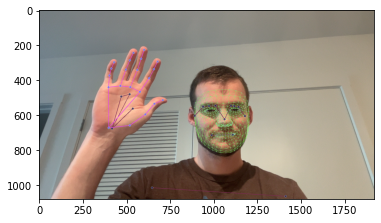

In [18]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [19]:
len(results.right_hand_landmarks.landmark)

21

In [20]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [21]:
result_test = extract_keypoints(results)

In [22]:
result_test

array([ 0.55374467,  0.57847399, -0.66325414, ...,  0.22418627,
        0.27638453, -0.01856922])

# 4. Setup Folders for Collection

In [36]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('/Users/stephenkullman/Documents/MP_Data2') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou', 'bye','please','yes','no'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 30

In [37]:
for action in actions:
  for sequence in range(no_sequences):
    try:
      os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
    except:
      pass

# 5. Collect Keypoint Values for Training and Testing

In [38]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, .5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(1000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, .5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    cap.release()

I0000 00:00:1713720280.981326       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 76.3), renderer: Apple M2


In [35]:
cv2.destroyAllWindows()
cv2.waitKey(1)
cap.release()

# 6. Preprocess Data and Create Labels and Features

In [39]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [40]:
label_map = {label:num for num, label in enumerate(actions)}

In [41]:
label_map

{'hello': 0,
 'thanks': 1,
 'iloveyou': 2,
 'bye': 3,
 'please': 4,
 'yes': 5,
 'no': 6}

In [42]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [43]:
np.array(sequences).shape

(210, 30, 1662)

In [44]:
np.array(labels).shape

(210,)

In [45]:
X = np.array(sequences)

In [46]:
X.shape

(210, 30, 1662)

In [47]:
y = to_categorical(labels).astype(int)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [49]:
y_test.shape

(11, 7)

# 7. Build and Train LSTM Neural Network

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard 

In [55]:
log_dir = os.path.join('/Users/stephenkullman/Desktop/Logs2')
tb_callback = TensorBoard(log_dir=log_dir)

In [56]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='leaky_relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='leaky_relu'))
model.add(LSTM(64, return_sequences=False, activation='leaky_relu'))
model.add(Dense(64, activation='leaky_relu'))
model.add(Dense(32, activation='leaky_relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [57]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [58]:
model.fit(X_train, y_train, epochs=1000, callbacks=[tb_callback])

Epoch 1/1000
7/7 [==============================] - 2s 51ms/step - loss: 2.0146 - categorical_accuracy: 0.1407
Epoch 2/1000
7/7 [==============================] - 0s 45ms/step - loss: 1.9517 - categorical_accuracy: 0.1206
Epoch 3/1000
7/7 [==============================] - 0s 33ms/step - loss: 1.9512 - categorical_accuracy: 0.1407
Epoch 4/1000
7/7 [==============================] - 0s 34ms/step - loss: 1.9723 - categorical_accuracy: 0.1457
Epoch 5/1000
7/7 [==============================] - 0s 33ms/step - loss: 1.9404 - categorical_accuracy: 0.2010
Epoch 6/1000
7/7 [==============================] - 0s 49ms/step - loss: 1.9167 - categorical_accuracy: 0.2814
Epoch 7/1000
7/7 [==============================] - 0s 37ms/step - loss: 1.8373 - categorical_accuracy: 0.2764
Epoch 8/1000
7/7 [==============================] - 0s 49ms/step - loss: 1.9743 - categorical_accuracy: 0.2261
Epoch 9/1000
7/7 [==============================] - 0s 35ms/step - loss: 1.9088 - categorical_accuracy: 0.1558
E

In [64]:
!tensorboard --logdir "/Users/stephenkullman/Desktop/Logs2/train"

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.15.2 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [65]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 64)            442112    
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 7)                 231       
                                                                 
Total params: 596807 (2.28 MB)
Trainable params: 59680

# 8. Make Predictions

In [66]:
res = model.predict(X_test)

1/1 [==============================] - 0s 354ms/step


In [67]:
actions[np.argmax(res[4])]

'please'

In [68]:
actions[np.argmax(y_test[4])]

'please'

# 9. Save Weights

In [69]:
model.save('/Users/stephenkullman/Desktop/School of Data Science/Deep Learning/Project/SixClassWeights.h5')

/Users/stephenkullman/anaconda3/envs/bayesml/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 10. Evaluation using Confusion Matrix and Accuracy

In [70]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [71]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 28ms/step


In [72]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [73]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[10,  0],
        [ 0,  1]],

       [[ 9,  0],
        [ 0,  2]],

       [[ 9,  0],
        [ 0,  2]],

       [[ 8,  0],
        [ 0,  3]],

       [[10,  0],
        [ 0,  1]],

       [[10,  0],
        [ 0,  1]],

       [[10,  0],
        [ 0,  1]]])

In [74]:
accuracy_score(ytrue, yhat)

1.0

# 11. Test in Real Time

In [75]:
from scipy import stats

In [76]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [85]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        #print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            #print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            #image = prob_viz(res, actions, image, colors)
            
        #cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cv2.destroyAllWindows()
    cap.release()
    cv2.waitKey(1)

I0000 00:00:1713994037.487126       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 76.3), renderer: Apple M2


In [80]:
cv2.destroyAllWindows()
cap.release()
cv2.waitKey(1)

-1